# Numerical modeling with to Landlab (part 2)

*CU Boulder GEOL 3600/5700 Introduction to Python Programming for Geoscientists, November 2023*

### Goals

- Recognize the basic elements of a forward-time, center-space finite-difference solution to the diffusion equation
- Become familiar with 2D numerical modeling with Landlab

## Simulating a hill

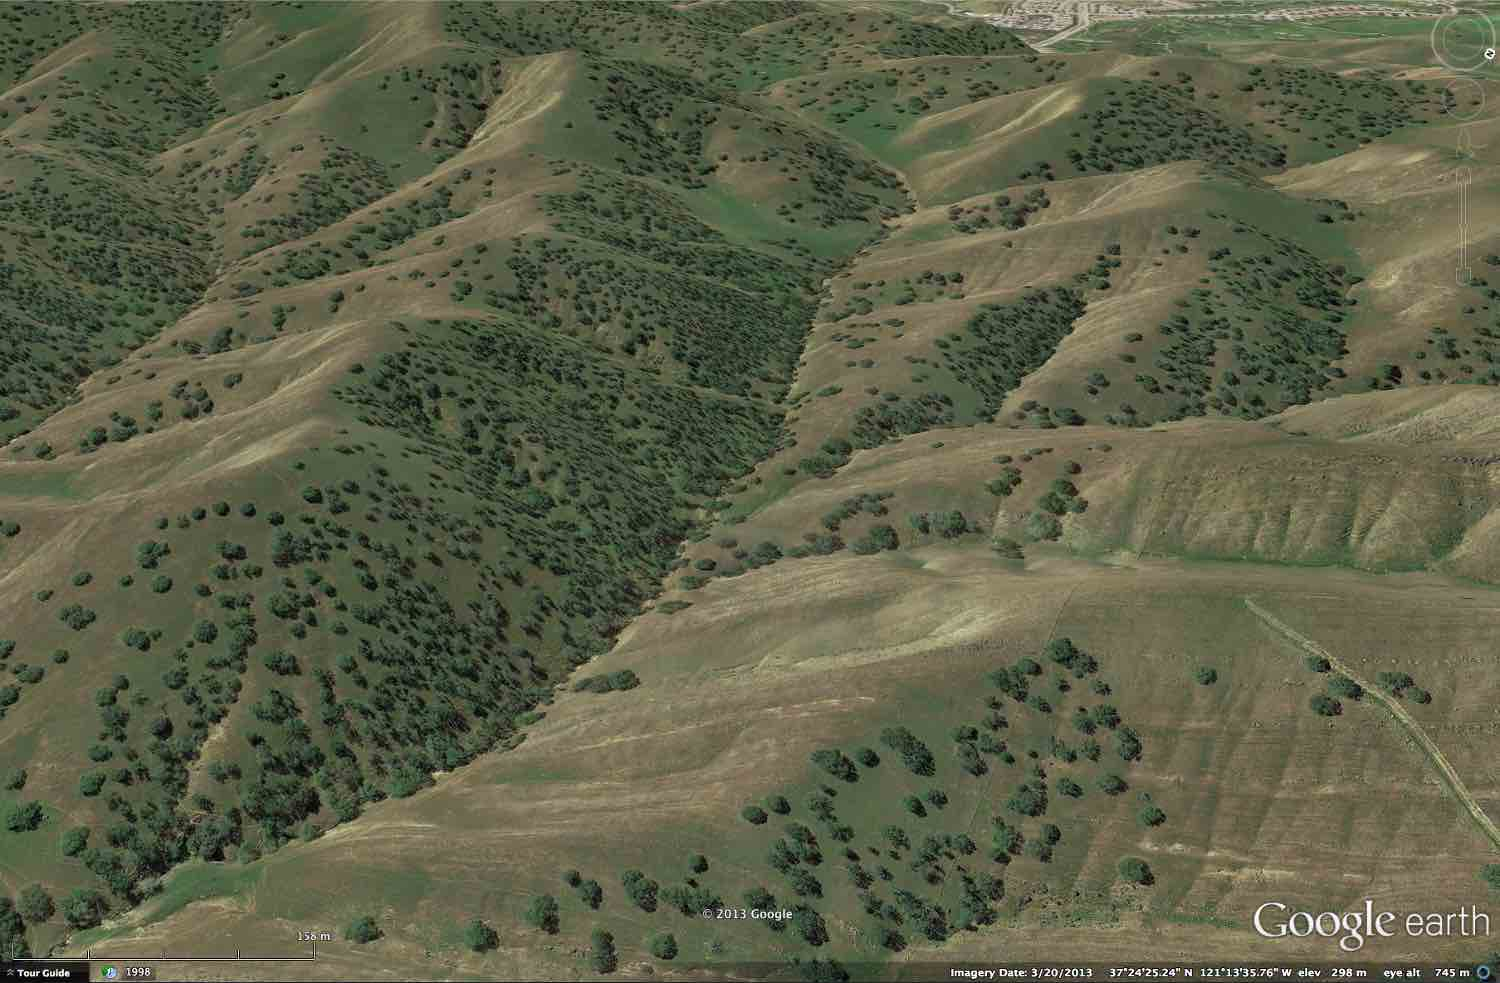

### The math

#### Soil flux in two dimensions

When we extend our domain from a single profile (one dimension) to a horizontal plane (two dimensions), the flux law has two components, one in each direction:

$$q_x = -K_c \frac{\partial z}{\partial x}\text{ ($x$ direction)}$$

$$q_y = -K_c \frac{\partial z}{\partial y}\text{ ($y$ direction)}$$

where again $z$ is the height of the land, $q_x$ represents the volume of soil flow per year per meter in the $x$ direction, $q_y$ represents the same in the $y$ direction, and the factor $K_c$ ($c$ for "creep") has units of square meters per year.

#### Mass conservation

Where soil creep is the only major process shaping the land, we can also write a mass conservation equation that tells us how fast the land height, $z$, is rising or falling at a given point:

$$\frac{\partial z}{\partial t} = -\left( \frac{\partial q_x}{\partial x} + \frac{\partial q_y}{\partial y} \right)$$

The terms between parentheses represent the **flux divergence**. Sounds fancy, but the concept is actually simple: it's math-speak for "add up all in the incoming and outgoing fluxes around the perimeter of our cell, and divide by the cell's area".

#### Numerical treatment

1. Calculate terrain gradient in betwen each pair of cells

2. Calculate soil flux ($q$) at each of these locations

3. For each cell, add up all the inflows and outflows to get the net volume flow (could be + or -)

4. Divide the net volume flow by cell surface area => divergence


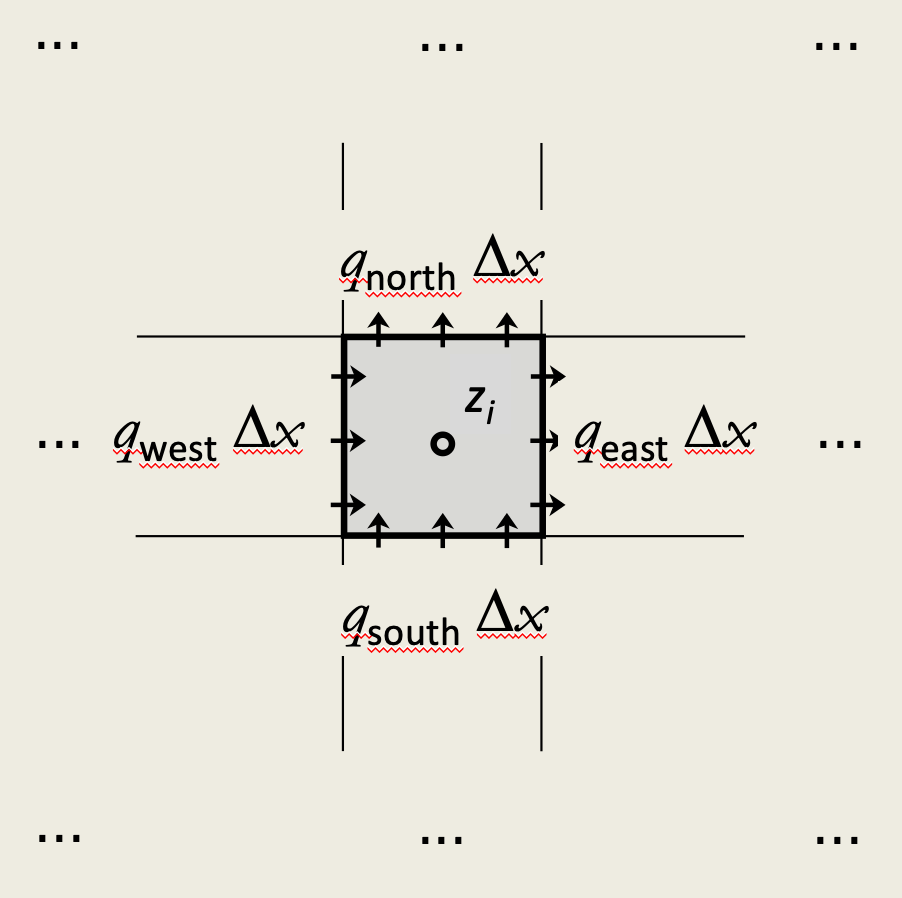

### About Landlab RasterModelGrid

Landlab provides several different types, as Python classes. Here we'll use a [`RasterModelGrid`](https://landlab.readthedocs.io/en/master/reference/grid/raster.html).

Here's a tiny grid as viewed in the [Grid Sketchbook]():

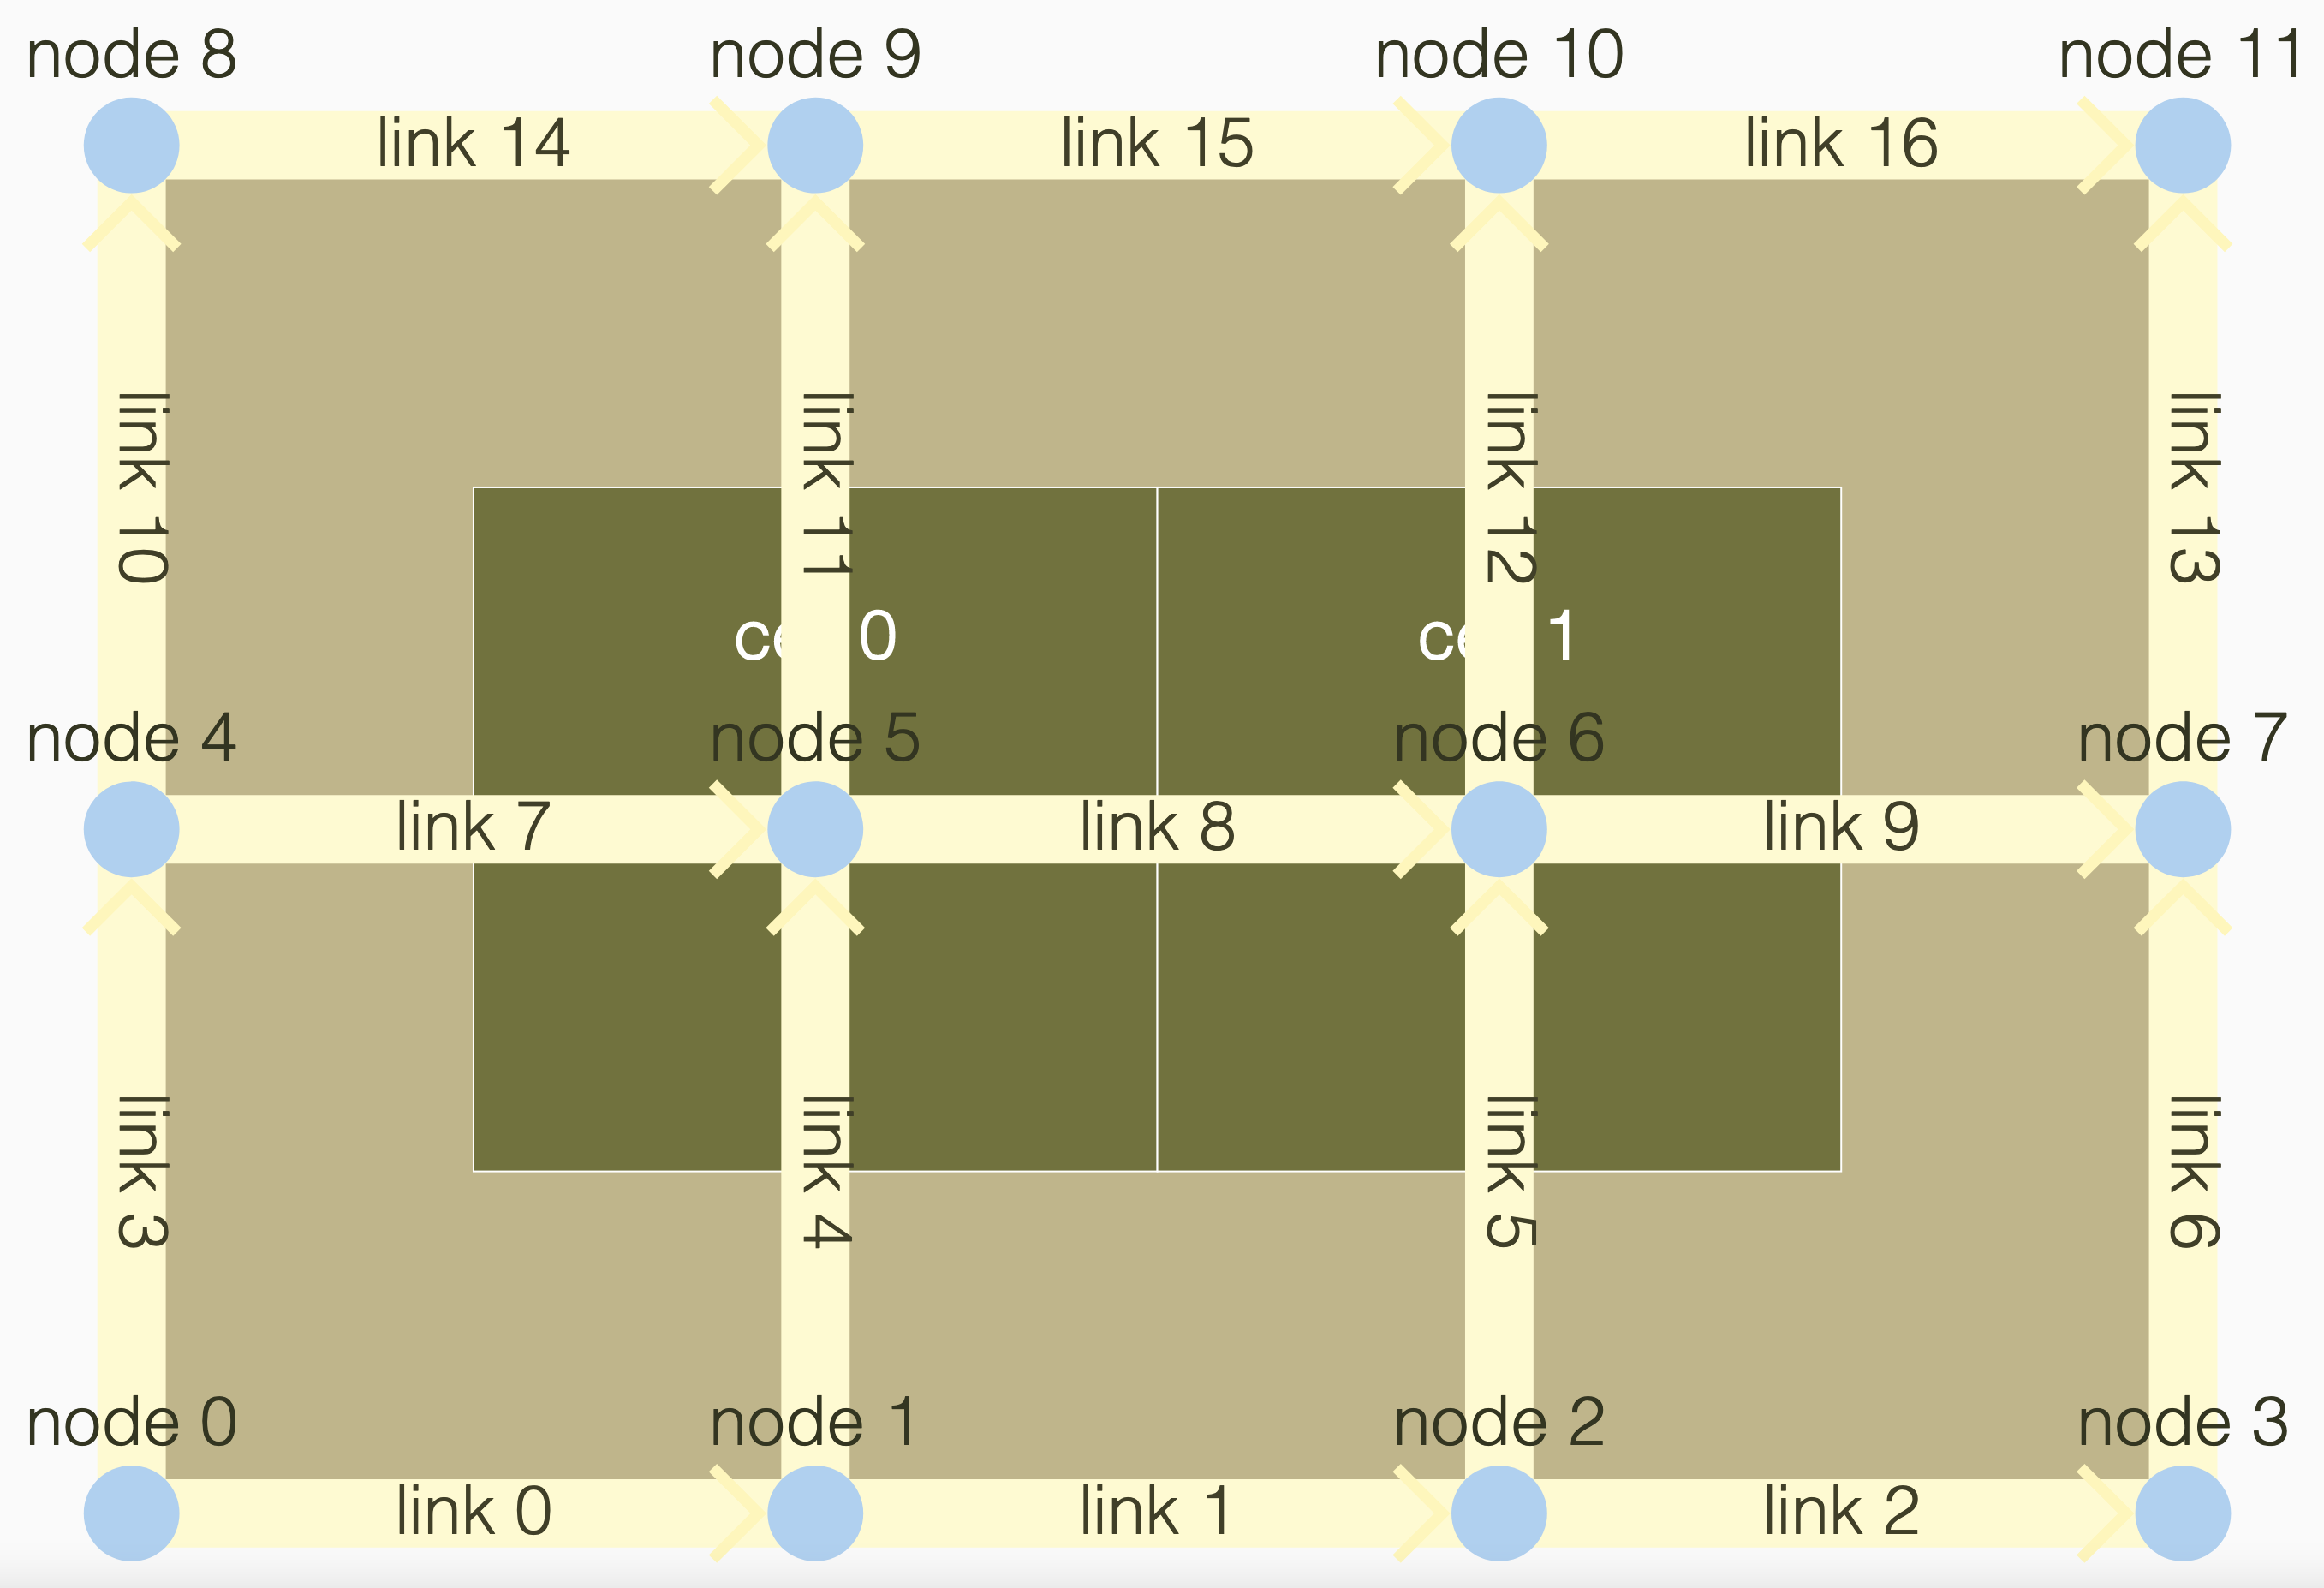

Our strategy will be to track elevation at *nodes*, and *gradient* and *soil flux* at links. The *flux divergence* will be applied to cells: for each cell, we'll add up all the incoming/outgoing soil, and divide by the cell area to get its rate of elevation gain (sediment accumulation) or loss (erosion).

### The algorithm, in pseudocode

```
# Initialize
Define parameters
Create grid
Set up arrays

# Run
FOR each time step DO
    Lower the elevation at the boundary nodes
    Calculate the gradients at links
    Calculate flux values at links
    Calculate divergence at core nodes
    Update z values for the new time step

# Finalize
Plot and/or report final values
```

### Translating to code: Initialize

- Define parameters: as in our 1D example, we'll define variables to hold values for $K_c$, the boundary lowering rate, time step size, etc.

- We'll use the syntax we met before to create a new object of type `RasterModelGrid`:
```
RasterModelGrid(shape, xy_spacing)
```

- We'll create a numpy array to hold the value of elevation at each grid node

In [ ]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from landlab import RasterModelGrid, imshow_grid

In [ ]:
# INITIALIZE

# Define parameters
Kc = 0.01  # transport coefficient, m2/y
initial_elev = 1600.0  # starting elevation values, m
boundary_lowering_rate = 0.001  # lowering rate of "streams", m/y
nrows = 3  # number of node rows (we'll increase it later)
ncols = 4  # number of node columns (we'll increase it later)
dx = 10.0  # grid node spacing, m
nsteps = 1  # number of time steps (we'll increase it later)
dt = 500.0 # time-step duration, y

# Create a grid object
grid = RasterModelGrid((nrows, ncols), xy_spacing=dx)  # tuple of (rows, cols); spacing

# Make an array for elevation
z = np.zeros(grid.number_of_nodes) + initial_elev  # one elev value per grid node

### Landlab grids: core and boundary nodes

By default, nodes in the grid interior are flagged as **core nodes**, and nodes on the perimeter are flagged as **boundary nodes**. The Landlab grid attribute `core_nodes` is an integer array containing the IDs of the core nodes, and the same for `boundary_nodes`. We can use these to index other node-based arrays.

In [ ]:
print("Core nodes:", grid.core_nodes)
print("Elevation values at core nodes:", z[grid.core_nodes])
print("Boundary nodes:", grid.boundary_nodes)
print("Elevation values at boundary nodes:", z[grid.boundary_nodes])

In [ ]:
grid.active_links

### Translating into code: time loop with boundary lowering

Below is a first version of a time loop:

In [ ]:
for _ in range(nsteps):
    
    # Lower elevations at boundary nodes
    z[grid.boundary_nodes] -= boundary_lowering_rate * dt
    
    # Calculate gradient at each link
    
    # Calculate soil flux at each link
    
    # Calculate net accumulation/erosion (i.e., flux divergence) at each node
    
    # Update elevation values at core nodes for the new time step


### Visualizing grid values with `imshow_grid`

The Landlab `imshow_grid()` function displays an image of values on the grid. Here's an example:

In [ ]:
imshow_grid(grid, z, colorbar_label="Elevation (m)")

### Calculating gradients

Strategy: calculate gradient between each pair of adjacent nodes, and store the value on the corresponding link.

Example: gradient at link 8 = `(z[6] - z[5]) / dx`

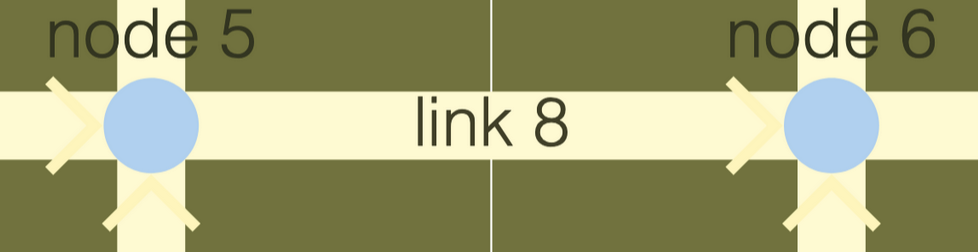

#### `calc_grad_at_link()`

The grid method `calc_grad_at_link()` performs this calculation for each pair of nodes. It takes an array of values defined at nodes, and returns an array of gradients at links:

In [ ]:
print(grid.calc_grad_at_link(z))

#### Calculating soil flux

We can use the result of `calc_grad_at_link()` to calculate the soil fluxes. The below version of our model adds this to the time loop:

In [ ]:
# INITIALIZE

# Define parameters
Kc = 0.01  # transport coefficient, m2/y
initial_elev = 1600.0  # starting elevation values, m
boundary_lowering_rate = 0.001  # lowering rate of "streams", m/y
nrows = 3  # number of node rows (we'll increase it later)
ncols = 4  # number of node columns (we'll increase it later)
dx = 10.0  # grid node spacing, m
nsteps = 1  # number of time steps (we'll increase it later)
dt = 500.0 # time-step duration, y

# Create a grid object
grid = RasterModelGrid((nrows, ncols), xy_spacing=dx)  # tuple of (rows, cols); spacing

# Make an array for elevation
z = np.zeros(grid.number_of_nodes) + initial_elev  # one elev value per grid node

In [ ]:
for _ in range(nsteps):
    
    # Lower elevations at boundary nodes
    z[grid.boundary_nodes] -= boundary_lowering_rate * dt
    
    # Calculate gradient at each link
    grad_z = grid.calc_grad_at_link(z)
    
    # Calculate soil flux at each link
    q = -Kc * grad_z
    
    # Calculate net accumulation/erosion (i.e., flux divergence) at each node
    
    # Update elevation values at core nodes for the new time step


In [ ]:
print("Soil flux at links after one time step:", q)

### Calculating flux divergence with `calc_flux_div_at_node()`

The next step is to calculate the inflow and outflow of soil at each grid node. For example, take a look at cell 

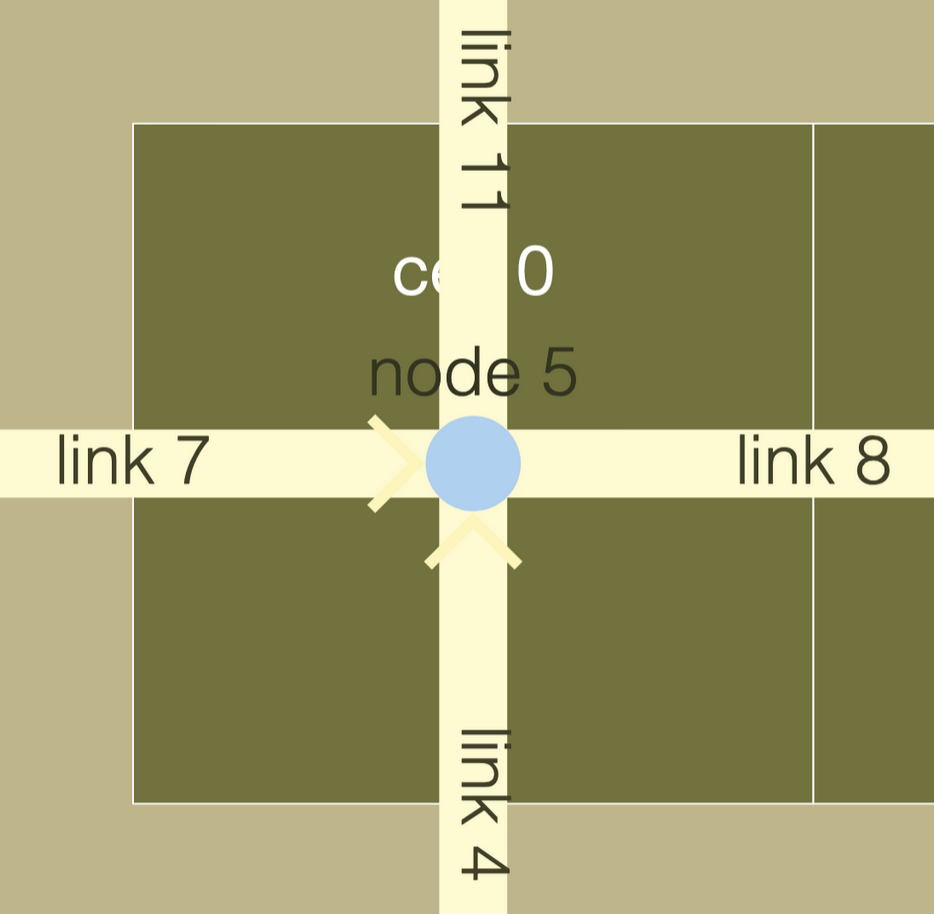

$$\text{net accumulation rate} = \frac{\text{incoming volume} - \text{outgoing volume}}{\text{cell area}}$$

$$\text{net accumulation rate} = \frac{(q_7\Delta x + q_4\Delta x) - (q_8\Delta x + q_{11}\Delta x)}{\Delta x^2}$$

The `calc_flux_div_at_node()` grid method does this for us. Because there are no cells at the perimeter nodes, these points are assigned zeros.

In [ ]:
dqdx = grid.calc_flux_div_at_node(q)
print("Soil flux divergence, in m/y:")
print(dqdx)

### Updating the elevations

The final step in our loop will be to extrapolate the rate of sediment accumulation (or loss, if negative) for one time step. We **only** want to do this for the core nodes. Here's an example (which also uses the numpy array `reshape` method to arrange the values into a grid shape):

In [ ]:
z[grid.core_nodes] -= dqdx[grid.core_nodes] * dt
print("New elevation values after one time step:")
print(z.reshape((grid.number_of_node_rows, grid.number_of_node_columns)))

### Putting all the pieces together

In [ ]:
# INITIALIZE

# Define parameters
Kc = 0.01  # transport coefficient, m2/y
initial_elev = 1600.0  # starting elevation values, m
boundary_lowering_rate = 0.001  # lowering rate of "streams", m/y
nrows = 50  # number of node rows (we'll increase it later)
ncols = 80  # number of node columns (we'll increase it later)
dx = 10.0  # grid node spacing, m
nsteps = 1000  # number of time steps (we'll increase it later)
dt = 500.0 # time-step duration, y

# Create a grid object
grid = RasterModelGrid((nrows, ncols), xy_spacing=dx)  # tuple of (rows, cols); spacing

# Make an array for elevation
z = np.zeros(grid.number_of_nodes) + initial_elev  # one elev value per grid node

In [ ]:
for _ in range(nsteps):
    
    # Lower elevations at boundary nodes
    z[grid.boundary_nodes] -= boundary_lowering_rate * dt
    
    # Calculate gradient at each link
    grad_z = grid.calc_grad_at_link(z)
    
    # Calculate soil flux at each link
    q = -Kc * grad_z
    
    # Calculate net accumulation/erosion (i.e., flux divergence) at each node
    dqdx = grid.calc_flux_div_at_node(q)
    
    # Update elevation values at core nodes for the new time step
    z[grid.core_nodes] -= dqdx[grid.core_nodes] * dt


### Displaying a surface plot

Now let's make a surface plot of the resulting landform.

(Note: Landlab arrays are 1D, but the matplotlib `plot_surface()` function wants 2D arrays, so we have to reshape them before plotting.)

In [ ]:
def surface_plot(grid, elevation):

    # "turn on" 3D plotting
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

    # plot_surface() wants 2d arrays, so we have to reshape our Landlab arrays
    nrows = grid.number_of_node_rows
    ncols = grid.number_of_node_columns
    x2d = grid.x_of_node.reshape((nrows, ncols))
    y2d = grid.y_of_node.reshape((nrows, ncols))
    z2d = elevation.reshape((nrows, ncols))

    # make a surface plot
    ax.plot_surface(x2d, y2d, z2d)
    ax.set_xlabel('East-west distance (m)')
    ax.set_ylabel('North-south distance (m)')
    ax.set_zlabel('Elevation (m)')

In [ ]:
surface_plot(grid, z)

### <div style="color:green">In-class practice: playing with the model</div>

Increase the number of rows and columns (try 50 x 80 for example), and the number of time steps. Then experiment with your model.

1. Does the height of the hill (relative to the base) keep rising, or does it reach a steady state?

2. What happens if you increase the lowering rate?

3. What happens if you reduce the lowering rate?

4. What happens if you lower the creep coefficient by 4x? (e.g., drier climate)

5. What happens if you increase the creep coefficient by 4x? (e.g., wetter climate)

6. What happens if you change the size or shape of the grid?

In [ ]:
# in-the-moment supplement: working with closed boundaries
grid.status_at_node[grid.nodes_at_right_edge] = grid.BC_NODE_IS_CLOSED
grid.status_at_node[grid.nodes_at_left_edge] = grid.BC_NODE_IS_CLOSED

z[:] = 1600.0 # reset for a new experiment

In [ ]:
# modified main loop to zero out fluxes on inactive links
for _ in range(nsteps):
    
    # Lower elevations at boundary nodes
    z[grid.boundary_nodes] -= boundary_lowering_rate * dt
    
    # Calculate gradient at each link
    grad_z = grid.calc_grad_at_link(z)
    grad_z[grid.status_at_link != grid.BC_LINK_IS_ACTIVE] = 0.0
    
    # Calculate soil flux at each link
    q = -Kc * grad_z
    
    # Calculate net accumulation/erosion (i.e., flux divergence) at each node
    dqdx = grid.calc_flux_div_at_node(q)
    
    # Update elevation values at core nodes for the new time step
    z[grid.core_nodes] -= dqdx[grid.core_nodes] * dt


In [ ]:
surface_plot(grid, z)

### About time steps

For a finite-difference diffusion model, using too large a time step will result in **numerical instability**: oscillations in value that get bigger and bigger until they're too big for floating point variables to handle. The time step constraint depends on the grid spacing and the diffusion coefficient:

$$\Delta t \le \frac{\Delta x^2}{2K_c}$$

It's an example of how there is no free lunch with any numerical method. Explicit finite-difference (and the related finite-volume) methods tend to be easier to program than other methods but usually require smaller time steps. 

### Review so far

- Many numerical models in the natural sciences divide the world into grid boxes and simulate processes by calculating flows (of soil, water, air, heat, momentum, etc.) between grid boxes.

- Finite-differencing is one of many *numerical methods*

- Landlab grids make it easier to write 2D numerical models

## Landlab *components* (optional; if time)

A Landlab *component* is a Python class designed to simulate a particular process. Examples:

- `FlowAccumulator`: calculate the pathways of surface flow on digital topography, and the resulting *drainage area* and *water discharge* at each node.

- `StreamPowerEroder`: calculate stream erosion at each grid node using the local slope and discharge.

- `LinearDiffuser`: calculate landform evolution by soil creep (same as our model above!)

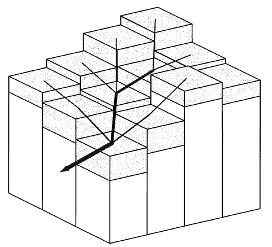


A component's constructor takes a grid object as the first argument, and component-specific parameters after that. Most components have a `run_one_step()` method that advances them in time.

Example: a simple landscape evolution model.



In [ ]:
# imports
import numpy as np
from landlab import RasterModelGrid, imshow_grid
from landlab.components import (FlowAccumulator,
                                StreamPowerEroder,
                                LinearDiffuser)

# make a grid
grid = RasterModelGrid((80, 128), xy_spacing=100.0)

# make a field and initialize it
topo = grid.add_zeros('topographic__elevation', at='node')
topo[grid.core_nodes] += np.random.rand(len(grid.core_nodes))

# instantiate components
fa = FlowAccumulator(grid, flow_director='D8')
sp = StreamPowerEroder(grid, K_sp=0.0001)
ld = LinearDiffuser(grid, linear_diffusivity=0.01)

# run model
for i in range(1000):
    topo[grid.core_nodes] += 0.1  # uplift
    ld.run_one_step(dt=250.0)     # soil creep / hillslope processes
    fa.run_one_step()             # route flow
    sp.run_one_step(dt=250.0)     # water erosion

# plot
imshow_grid(grid, topo, colorbar_label='Elevation (m)')

### <div style="color:green">Optional in-class practice: play with the simulation</div>

- Try commenting out one or two components in the main loop and re-running to experiment with what each one does

- The code above hard-codes a several values (i.e., uses a number instead of a previously defined variable), which isn't best practice; how might you modify the code to avoid hard-coding?

- Try changing the parameters `K_sp`, `linear_diffusivity`, and the amount of uplift at each time step. What are some ways you can make the terrain higher? Lower? Smoother? More rugged?

- What do you think the `D8` means in the `FlowAccumulator`? What happens when you remove out this optional parameter?

- How does the first line in the loop differ from the way we handled boundaries in our hillslope model?

- Use the `help()` function to learn more about the inputs for each component

In [ ]:
p = np.linspace(0.01, 1, 100)
plt.plot(p, -np.log2(p))

### Where to learn more

- [Available Landlab components](https://landlab.readthedocs.io/en/latest/reference/components/index.html#api-components)
- [Tutorials](https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html)
- [General documentation pages](https://landlab.github.io)